In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json

In [10]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [11]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [12]:
def convert_data_to_tensors(data, word_vectors):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            if word in word_vectors:
                embedding.append(word_vectors[word])
            else:
                embedding.append([0] * len(word_vectors['hello']))  # Use a zero vector for unknown words
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len =70
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(word_vectors['hello'])] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [13]:
x_train = convert_data_to_tensors(train_data, word_vectors)
x_val = convert_data_to_tensors(val_data, word_vectors)
x_test = convert_data_to_tensors(test_data, word_vectors)

In [14]:
x_train.size()

torch.Size([8019, 70, 300])

In [15]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [16]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [17]:
y_train.size()

torch.Size([8019, 70])

In [18]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [19]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = GRUTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_5496/3909336609.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_5496/3909336609.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_5496/3909336609.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_5496/3909336609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/130, Train Loss: 1.3251069490871732, Val Loss: 0.8219832181930542, Val F1: 0.03403986836383785, Train F1: 0.033596625243272775


  2%|▋                                          | 2/130 [00:05<06:08,  2.88s/it]

Epoch 2/130, Train Loss: 0.7664118664605277, Val Loss: 0.7023807764053345, Val F1: 0.07284897297115664, Train F1: 0.052572247421585755


  2%|▉                                          | 3/130 [00:08<06:04,  2.87s/it]

Epoch 3/130, Train Loss: 0.6687090150893681, Val Loss: 0.6160088181495667, Val F1: 0.0990209592504029, Train F1: 0.08321751862954103


  3%|█▎                                         | 4/130 [00:11<06:00,  2.86s/it]

Epoch 4/130, Train Loss: 0.5904734607726808, Val Loss: 0.5514668226242065, Val F1: 0.1538732220471442, Train F1: 0.13266606416761692


  4%|█▋                                         | 5/130 [00:14<05:59,  2.87s/it]

Epoch 5/130, Train Loss: 0.5359406386102948, Val Loss: 0.5124926567077637, Val F1: 0.19536842542447289, Train F1: 0.18016231778567415


  5%|█▉                                         | 6/130 [00:17<05:59,  2.90s/it]

Epoch 6/130, Train Loss: 0.5009485270295825, Val Loss: 0.4791700541973114, Val F1: 0.21362644653512494, Train F1: 0.20625301635064633


  5%|██▎                                        | 7/130 [00:20<05:56,  2.90s/it]

Epoch 7/130, Train Loss: 0.47395676894793437, Val Loss: 0.46016010642051697, Val F1: 0.22303530345707523, Train F1: 0.22117698813103895


  6%|██▋                                        | 8/130 [00:23<05:57,  2.93s/it]

Epoch 8/130, Train Loss: 0.4544842304691436, Val Loss: 0.4433853328227997, Val F1: 0.243379124955428, Train F1: 0.23861433003019544


  7%|██▉                                        | 9/130 [00:26<05:53,  2.92s/it]

Epoch 9/130, Train Loss: 0.4396473202440474, Val Loss: 0.4336855411529541, Val F1: 0.2716842625174168, Train F1: 0.25340923777878743


  8%|███▏                                      | 10/130 [00:28<05:48,  2.90s/it]

Epoch 10/130, Train Loss: 0.42849608167769415, Val Loss: 0.4239872395992279, Val F1: 0.2718856253089696, Train F1: 0.26852106598310616


  8%|███▌                                      | 11/130 [00:31<05:43,  2.89s/it]

Epoch 11/130, Train Loss: 0.4187233325034853, Val Loss: 0.41849952936172485, Val F1: 0.27629329691307847, Train F1: 0.27588951739875167


  9%|███▉                                      | 12/130 [00:34<05:39,  2.88s/it]

Epoch 12/130, Train Loss: 0.4093058350540343, Val Loss: 0.4110453128814697, Val F1: 0.28308513540179614, Train F1: 0.28148404774021146


 10%|████▏                                     | 13/130 [00:37<05:36,  2.87s/it]

Epoch 13/130, Train Loss: 0.40162967878674705, Val Loss: 0.40702781081199646, Val F1: 0.2942803337366178, Train F1: 0.29418232981359144


 11%|████▌                                     | 14/130 [00:40<05:37,  2.91s/it]

Epoch 14/130, Train Loss: 0.394743863079283, Val Loss: 0.4096751809120178, Val F1: 0.3024190274060516, Train F1: 0.30926177741125455


 12%|████▊                                     | 15/130 [00:43<05:35,  2.91s/it]

Epoch 15/130, Train Loss: 0.3882021809381152, Val Loss: 0.3986039459705353, Val F1: 0.31262902410592913, Train F1: 0.3167861143167399


 12%|█████▏                                    | 16/130 [00:46<05:32,  2.92s/it]

Epoch 16/130, Train Loss: 0.382045656915695, Val Loss: 0.39597901701927185, Val F1: 0.3339399293573033, Train F1: 0.3301813215636916


 13%|█████▍                                    | 17/130 [00:49<05:29,  2.91s/it]

Epoch 17/130, Train Loss: 0.3753462968364594, Val Loss: 0.3914496600627899, Val F1: 0.3368171785134059, Train F1: 0.3399648674486853


 14%|█████▊                                    | 18/130 [00:52<05:24,  2.90s/it]

Epoch 18/130, Train Loss: 0.3694890434779818, Val Loss: 0.3907579779624939, Val F1: 0.33571017479774246, Train F1: 0.352057084658132


 15%|██████▏                                   | 19/130 [00:55<05:20,  2.88s/it]

Epoch 19/130, Train Loss: 0.3651678524320088, Val Loss: 0.388244092464447, Val F1: 0.35321882790496884, Train F1: 0.35726732742682815


 15%|██████▍                                   | 20/130 [00:57<05:16,  2.88s/it]

Epoch 20/130, Train Loss: 0.3595574715780833, Val Loss: 0.38622888922691345, Val F1: 0.3567912604787213, Train F1: 0.3644041168599271


 16%|██████▊                                   | 21/130 [01:00<05:13,  2.87s/it]

Epoch 21/130, Train Loss: 0.354142610515867, Val Loss: 0.38758981227874756, Val F1: 0.3485032676715698, Train F1: 0.38076005717567646


 17%|███████                                   | 22/130 [01:03<05:09,  2.87s/it]

Epoch 22/130, Train Loss: 0.3500053395354559, Val Loss: 0.3831403851509094, Val F1: 0.3704687329119221, Train F1: 0.3858394829022506


 18%|███████▍                                  | 23/130 [01:06<05:10,  2.90s/it]

Epoch 23/130, Train Loss: 0.3448893106172955, Val Loss: 0.38393259048461914, Val F1: 0.3711517767696477, Train F1: 0.3923846274828947


 18%|███████▊                                  | 24/130 [01:09<05:10,  2.93s/it]

Epoch 24/130, Train Loss: 0.3411541335166447, Val Loss: 0.3797960877418518, Val F1: 0.37606109684320754, Train F1: 0.40061787389182363


 19%|████████                                  | 25/130 [01:12<05:05,  2.91s/it]

Epoch 25/130, Train Loss: 0.33581746239510796, Val Loss: 0.3796001970767975, Val F1: 0.3745978733451998, Train F1: 0.40462881707672915


 20%|████████▍                                 | 26/130 [01:15<05:01,  2.90s/it]

Epoch 26/130, Train Loss: 0.3319396906428867, Val Loss: 0.37850621342658997, Val F1: 0.3778410181633778, Train F1: 0.41313205962846333


 21%|████████▋                                 | 27/130 [01:18<05:00,  2.92s/it]

Epoch 27/130, Train Loss: 0.3275412708993942, Val Loss: 0.37821993231773376, Val F1: 0.38145383056899124, Train F1: 0.4155006874451215


 22%|█████████                                 | 28/130 [01:21<04:55,  2.90s/it]

Epoch 28/130, Train Loss: 0.32370676738875254, Val Loss: 0.3781181275844574, Val F1: 0.3853094569157316, Train F1: 0.4222168401958289


 22%|█████████▎                                | 29/130 [01:23<04:51,  2.88s/it]

Epoch 29/130, Train Loss: 0.3189650797654712, Val Loss: 0.3788054585456848, Val F1: 0.38526642698884866, Train F1: 0.42833976579325805


 23%|█████████▋                                | 30/130 [01:26<04:47,  2.87s/it]

Epoch 30/130, Train Loss: 0.3152501124238211, Val Loss: 0.3869677484035492, Val F1: 0.3922594372276556, Train F1: 0.43087418558681306


 24%|██████████                                | 31/130 [01:29<04:45,  2.88s/it]

Epoch 31/130, Train Loss: 0.31118866753956625, Val Loss: 0.381107896566391, Val F1: 0.37980168729393876, Train F1: 0.44018399136468495


 25%|██████████▎                               | 32/130 [01:32<04:42,  2.88s/it]

Epoch 32/130, Train Loss: 0.3077868346184019, Val Loss: 0.3847017288208008, Val F1: 0.38364834847619, Train F1: 0.444765335561933


 25%|██████████▋                               | 33/130 [01:35<04:38,  2.88s/it]

Epoch 33/130, Train Loss: 0.3040526972876655, Val Loss: 0.3828137218952179, Val F1: 0.41882386690154383, Train F1: 0.4471770632684684


 26%|██████████▉                               | 34/130 [01:38<04:36,  2.88s/it]

Epoch 34/130, Train Loss: 0.2992830735350412, Val Loss: 0.381269246339798, Val F1: 0.3883472329625324, Train F1: 0.456945869212306


 27%|███████████▎                              | 35/130 [01:41<04:32,  2.87s/it]

Epoch 35/130, Train Loss: 0.2946332707291558, Val Loss: 0.38175758719444275, Val F1: 0.40469947121800653, Train F1: 0.4580550977813217


 28%|███████████▋                              | 36/130 [01:44<04:30,  2.88s/it]

Epoch 36/130, Train Loss: 0.2908412374201275, Val Loss: 0.3860941231250763, Val F1: 0.4111421198960117, Train F1: 0.46659105361752384


 28%|███████████▉                              | 37/130 [01:46<04:27,  2.88s/it]

Epoch 37/130, Train Loss: 0.2868172985220712, Val Loss: 0.3875090777873993, Val F1: 0.3988607587000684, Train F1: 0.47303060395565466


 29%|████████████▎                             | 38/130 [01:49<04:24,  2.87s/it]

Epoch 38/130, Train Loss: 0.28279346677045974, Val Loss: 0.3872831463813782, Val F1: 0.39796293026782464, Train F1: 0.47599102647726466


 30%|████████████▌                             | 39/130 [01:52<04:21,  2.87s/it]

Epoch 39/130, Train Loss: 0.2785368826654222, Val Loss: 0.3950965106487274, Val F1: 0.39116371053748256, Train F1: 0.4812794395904975


 31%|████████████▉                             | 40/130 [01:55<04:21,  2.90s/it]

Epoch 40/130, Train Loss: 0.27444069442294894, Val Loss: 0.39281341433525085, Val F1: 0.4056700778177611, Train F1: 0.4933641165697293


 32%|█████████████▏                            | 41/130 [01:58<04:18,  2.90s/it]

Epoch 41/130, Train Loss: 0.27046063305839657, Val Loss: 0.3961418569087982, Val F1: 0.4138231953931527, Train F1: 0.49589653177453985


 32%|█████████████▌                            | 42/130 [02:01<04:14,  2.89s/it]

Epoch 42/130, Train Loss: 0.26715443555324797, Val Loss: 0.40896084904670715, Val F1: 0.3968631162286568, Train F1: 0.5071512303450619


 33%|█████████████▉                            | 43/130 [02:04<04:10,  2.88s/it]

Epoch 43/130, Train Loss: 0.2626233730051253, Val Loss: 0.403477281332016, Val F1: 0.40666500450885407, Train F1: 0.5040602294402095


 34%|██████████████▏                           | 44/130 [02:07<04:08,  2.89s/it]

Epoch 44/130, Train Loss: 0.2585327530664111, Val Loss: 0.40814706683158875, Val F1: 0.410660946777232, Train F1: 0.5173386657111366


 35%|██████████████▌                           | 45/130 [02:10<04:06,  2.90s/it]

Epoch 45/130, Train Loss: 0.2562920247751569, Val Loss: 0.4047001302242279, Val F1: 0.4157671387608253, Train F1: 0.5164356610241732


 35%|██████████████▊                           | 46/130 [02:13<04:03,  2.90s/it]

Epoch 46/130, Train Loss: 0.25274543771668084, Val Loss: 0.4148466885089874, Val F1: 0.40867806539918167, Train F1: 0.5174254938830957


 36%|███████████████▏                          | 47/130 [02:15<04:00,  2.90s/it]

Epoch 47/130, Train Loss: 0.24759630740634977, Val Loss: 0.4179937243461609, Val F1: 0.4114203176509082, Train F1: 0.5297424953162043


 37%|███████████████▌                          | 48/130 [02:18<03:57,  2.89s/it]

Epoch 48/130, Train Loss: 0.24288242534985618, Val Loss: 0.42102885246276855, Val F1: 0.4134872290692237, Train F1: 0.5366344230477494


 38%|███████████████▊                          | 49/130 [02:21<03:53,  2.89s/it]

Epoch 49/130, Train Loss: 0.23963339508525908, Val Loss: 0.4256669282913208, Val F1: 0.41200785336682566, Train F1: 0.5492535924425864


 38%|████████████████▏                         | 50/130 [02:24<03:50,  2.88s/it]

Epoch 50/130, Train Loss: 0.23516045581726802, Val Loss: 0.43447592854499817, Val F1: 0.40108992392024434, Train F1: 0.5475180488529451


 39%|████████████████▍                         | 51/130 [02:27<03:47,  2.88s/it]

Epoch 51/130, Train Loss: 0.2321216201498395, Val Loss: 0.4334747791290283, Val F1: 0.4158494558304712, Train F1: 0.5534663364817918


 40%|████████████████▊                         | 52/130 [02:30<03:45,  2.89s/it]

Epoch 52/130, Train Loss: 0.22784487926770772, Val Loss: 0.4350874722003937, Val F1: 0.4226487681707116, Train F1: 0.5597572317946116


 41%|█████████████████                         | 53/130 [02:33<03:44,  2.92s/it]

Epoch 53/130, Train Loss: 0.22362629052192445, Val Loss: 0.4496849477291107, Val F1: 0.4016437117247435, Train F1: 0.5664915086853407


 42%|█████████████████▍                        | 54/130 [02:36<03:41,  2.91s/it]

Epoch 54/130, Train Loss: 0.2212532628623266, Val Loss: 0.4607744514942169, Val F1: 0.39765359962272134, Train F1: 0.5740059974724393


 42%|█████████████████▊                        | 55/130 [02:39<03:37,  2.90s/it]

Epoch 55/130, Train Loss: 0.21677400834030575, Val Loss: 0.4542529582977295, Val F1: 0.4141667045902534, Train F1: 0.5840624015408985


 43%|██████████████████                        | 56/130 [02:41<03:33,  2.89s/it]

Epoch 56/130, Train Loss: 0.21239869201940204, Val Loss: 0.46169599890708923, Val F1: 0.404149340225768, Train F1: 0.5862543775971345


 44%|██████████████████▍                       | 57/130 [02:44<03:30,  2.88s/it]

Epoch 57/130, Train Loss: 0.2082466511499314, Val Loss: 0.4678054451942444, Val F1: 0.40640424384407764, Train F1: 0.5932653523251982


 45%|██████████████████▋                       | 58/130 [02:47<03:27,  2.88s/it]

Epoch 58/130, Train Loss: 0.2044466050371291, Val Loss: 0.4729684293270111, Val F1: 0.4093269131655496, Train F1: 0.5994417824204469


 45%|███████████████████                       | 59/130 [02:50<03:24,  2.88s/it]

Epoch 59/130, Train Loss: 0.20152459376388127, Val Loss: 0.48499640822410583, Val F1: 0.40105045911266257, Train F1: 0.6049062916893317


 46%|███████████████████▍                      | 60/130 [02:53<03:21,  2.88s/it]

Epoch 60/130, Train Loss: 0.19671812085878282, Val Loss: 0.4838408827781677, Val F1: 0.4070136562078408, Train F1: 0.6154315139027852


 47%|███████████████████▋                      | 61/130 [02:56<03:18,  2.88s/it]

Epoch 61/130, Train Loss: 0.19405115998926617, Val Loss: 0.5002097487449646, Val F1: 0.39733929096937926, Train F1: 0.6173704387491762


 48%|████████████████████                      | 62/130 [02:59<03:15,  2.88s/it]

Epoch 62/130, Train Loss: 0.19061941026695192, Val Loss: 0.49975067377090454, Val F1: 0.41332437359486746, Train F1: 0.6267718597716695


 48%|████████████████████▎                     | 63/130 [03:02<03:12,  2.88s/it]

Epoch 63/130, Train Loss: 0.18680701913341644, Val Loss: 0.5031898021697998, Val F1: 0.41167374779253074, Train F1: 0.6290394148365802


 49%|████████████████████▋                     | 64/130 [03:04<03:09,  2.88s/it]

Epoch 64/130, Train Loss: 0.18258369962374368, Val Loss: 0.5178919434547424, Val F1: 0.3969582685018657, Train F1: 0.6444711623030306


 50%|█████████████████████                     | 65/130 [03:07<03:06,  2.87s/it]

Epoch 65/130, Train Loss: 0.1784249579622632, Val Loss: 0.5244358777999878, Val F1: 0.40697182862906384, Train F1: 0.6492847289975443


 51%|█████████████████████▎                    | 66/130 [03:10<03:07,  2.93s/it]

Epoch 66/130, Train Loss: 0.17537131361545077, Val Loss: 0.5277144312858582, Val F1: 0.4116046062975831, Train F1: 0.654094056357093


 52%|█████████████████████▋                    | 67/130 [03:13<03:04,  2.92s/it]

Epoch 67/130, Train Loss: 0.17298118462638248, Val Loss: 0.5393739342689514, Val F1: 0.4002127143098257, Train F1: 0.662733190285912


 52%|█████████████████████▉                    | 68/130 [03:16<03:01,  2.92s/it]

Epoch 68/130, Train Loss: 0.1684169163779607, Val Loss: 0.55089271068573, Val F1: 0.3956008043790752, Train F1: 0.6693848037672271


 53%|██████████████████████▎                   | 69/130 [03:19<02:57,  2.91s/it]

Epoch 69/130, Train Loss: 0.16489004166353316, Val Loss: 0.5653393864631653, Val F1: 0.39847650642640164, Train F1: 0.6786302563579236


 54%|██████████████████████▌                   | 70/130 [03:22<02:54,  2.90s/it]

Epoch 70/130, Train Loss: 0.16120556895695035, Val Loss: 0.56789630651474, Val F1: 0.39893266535380384, Train F1: 0.68109201294327


 55%|██████████████████████▉                   | 71/130 [03:25<02:50,  2.90s/it]

Epoch 71/130, Train Loss: 0.15740344519653018, Val Loss: 0.5718835592269897, Val F1: 0.4011201111662416, Train F1: 0.6944408963781488


 55%|███████████████████████▎                  | 72/130 [03:28<02:47,  2.89s/it]

Epoch 72/130, Train Loss: 0.1539472947044978, Val Loss: 0.5949407815933228, Val F1: 0.39282748675745577, Train F1: 0.7025353672103525


 56%|███████████████████████▌                  | 73/130 [03:31<02:44,  2.89s/it]

Epoch 73/130, Train Loss: 0.15205562031931347, Val Loss: 0.5976606607437134, Val F1: 0.391161883662609, Train F1: 0.6991356666026107


 57%|███████████████████████▉                  | 74/130 [03:34<02:41,  2.89s/it]

Epoch 74/130, Train Loss: 0.14793715413127626, Val Loss: 0.606225311756134, Val F1: 0.3925180253003741, Train F1: 0.7123751292667969


 58%|████████████████████████▏                 | 75/130 [03:36<02:39,  2.89s/it]

Epoch 75/130, Train Loss: 0.14514253631470694, Val Loss: 0.6134309768676758, Val F1: 0.3825813490717975, Train F1: 0.7166791492150785


 58%|████████████████████████▌                 | 76/130 [03:39<02:35,  2.89s/it]

Epoch 76/130, Train Loss: 0.141870826601036, Val Loss: 0.6213865280151367, Val F1: 0.3960112844532869, Train F1: 0.7227306432006289


 59%|████████████████████████▉                 | 77/130 [03:42<02:32,  2.89s/it]

Epoch 77/130, Train Loss: 0.13803300356108045, Val Loss: 0.629756510257721, Val F1: 0.3968190137009231, Train F1: 0.7376131508497731


 60%|█████████████████████████▏                | 78/130 [03:45<02:30,  2.89s/it]

Epoch 78/130, Train Loss: 0.13518462803155656, Val Loss: 0.6409584283828735, Val F1: 0.3913323856267074, Train F1: 0.736766850150439


 61%|█████████████████████████▌                | 79/130 [03:48<02:29,  2.92s/it]

Epoch 79/130, Train Loss: 0.13377130622901615, Val Loss: 0.6492614150047302, Val F1: 0.3904953283856973, Train F1: 0.7404356585622848


 62%|█████████████████████████▊                | 80/130 [03:51<02:25,  2.91s/it]

Epoch 80/130, Train Loss: 0.13049097631185774, Val Loss: 0.6821405291557312, Val F1: 0.38415083414057494, Train F1: 0.7473590016646315


 62%|██████████████████████████▏               | 81/130 [03:54<02:22,  2.90s/it]

Epoch 81/130, Train Loss: 0.12868131779962116, Val Loss: 0.6757009625434875, Val F1: 0.38753066413608533, Train F1: 0.7490055740711528


 63%|██████████████████████████▍               | 82/130 [03:57<02:19,  2.90s/it]

Epoch 82/130, Train Loss: 0.1308297137655909, Val Loss: 0.6664072871208191, Val F1: 0.38751869216330553, Train F1: 0.7485239995954281


 64%|██████████████████████████▊               | 83/130 [04:00<02:16,  2.90s/it]

Epoch 83/130, Train Loss: 0.12465175879853112, Val Loss: 0.6813241243362427, Val F1: 0.3846400558555256, Train F1: 0.7644210500060638


 65%|███████████████████████████▏              | 84/130 [04:03<02:13,  2.90s/it]

Epoch 84/130, Train Loss: 0.1205414602207759, Val Loss: 0.7101941704750061, Val F1: 0.3774030206145585, Train F1: 0.7714247624333396


 65%|███████████████████████████▍              | 85/130 [04:05<02:10,  2.90s/it]

Epoch 85/130, Train Loss: 0.11683848996957143, Val Loss: 0.7016525864601135, Val F1: 0.3819410222787838, Train F1: 0.7766538093419945


 66%|███████████████████████████▊              | 86/130 [04:08<02:07,  2.90s/it]

Epoch 86/130, Train Loss: 0.11552349135043129, Val Loss: 0.7137758135795593, Val F1: 0.380279359071536, Train F1: 0.7813888455205366


 67%|████████████████████████████              | 87/130 [04:11<02:04,  2.90s/it]

Epoch 87/130, Train Loss: 0.11237584078122699, Val Loss: 0.7237935066223145, Val F1: 0.38069941450658035, Train F1: 0.7899538614483742


 68%|████████████████████████████▍             | 88/130 [04:14<02:01,  2.89s/it]

Epoch 88/130, Train Loss: 0.10897607498225712, Val Loss: 0.7541454434394836, Val F1: 0.3688292866286016, Train F1: 0.7986701285826748


 68%|████████████████████████████▊             | 89/130 [04:17<01:58,  2.90s/it]

Epoch 89/130, Train Loss: 0.10656691697381791, Val Loss: 0.7507691383361816, Val F1: 0.379002628492593, Train F1: 0.8009260207455318


 69%|█████████████████████████████             | 90/130 [04:20<01:55,  2.90s/it]

Epoch 90/130, Train Loss: 0.10410155450540876, Val Loss: 0.7615737915039062, Val F1: 0.37453611464489256, Train F1: 0.8092575782076495


 70%|█████████████████████████████▍            | 91/130 [04:23<01:52,  2.90s/it]

Epoch 91/130, Train Loss: 0.10156800231290242, Val Loss: 0.7729887366294861, Val F1: 0.37521606616781966, Train F1: 0.8107938885044873


 71%|█████████████████████████████▋            | 92/130 [04:26<01:51,  2.93s/it]

Epoch 92/130, Train Loss: 0.10077934416513594, Val Loss: 0.7655320763587952, Val F1: 0.37454202588108093, Train F1: 0.8124379437776116


 72%|██████████████████████████████            | 93/130 [04:29<01:47,  2.91s/it]

Epoch 93/130, Train Loss: 0.100786312350205, Val Loss: 0.7855428457260132, Val F1: 0.3734500165069981, Train F1: 0.8168772078561393


 72%|██████████████████████████████▎           | 94/130 [04:32<01:44,  2.91s/it]

Epoch 94/130, Train Loss: 0.09757200758608561, Val Loss: 0.7953929901123047, Val F1: 0.37048517016054533, Train F1: 0.8235085708267345


 73%|██████████████████████████████▋           | 95/130 [04:34<01:41,  2.90s/it]

Epoch 95/130, Train Loss: 0.09495766661942952, Val Loss: 0.8144487738609314, Val F1: 0.3690514804907907, Train F1: 0.8232209471278316


 74%|███████████████████████████████           | 96/130 [04:37<01:38,  2.90s/it]

Epoch 96/130, Train Loss: 0.09187190199182146, Val Loss: 0.8263423442840576, Val F1: 0.3648878600856888, Train F1: 0.833681082150972


 75%|███████████████████████████████▎          | 97/130 [04:40<01:35,  2.90s/it]

Epoch 97/130, Train Loss: 0.09095415910558095, Val Loss: 0.8302630186080933, Val F1: 0.36292495659846413, Train F1: 0.8290055664184155


 75%|███████████████████████████████▋          | 98/130 [04:43<01:32,  2.89s/it]

Epoch 98/130, Train Loss: 0.08840203143301464, Val Loss: 0.8374761343002319, Val F1: 0.36795251953685476, Train F1: 0.8402471718350364


 76%|███████████████████████████████▉          | 99/130 [04:46<01:29,  2.89s/it]

Epoch 99/130, Train Loss: 0.08575506041210795, Val Loss: 0.8628898859024048, Val F1: 0.3590486703450187, Train F1: 0.8443811167499844


 77%|███████████████████████████████▌         | 100/130 [04:49<01:26,  2.89s/it]

Epoch 100/130, Train Loss: 0.08791726141694993, Val Loss: 0.8630620837211609, Val F1: 0.3665622165793831, Train F1: 0.8364309228930078


 78%|███████████████████████████████▊         | 101/130 [04:52<01:24,  2.91s/it]

Epoch 101/130, Train Loss: 0.08347698774129625, Val Loss: 0.8737049102783203, Val F1: 0.35847399688938525, Train F1: 0.8526439216041668


 78%|████████████████████████████████▏        | 102/130 [04:55<01:21,  2.90s/it]

Epoch 102/130, Train Loss: 0.08107387889472265, Val Loss: 0.8972505331039429, Val F1: 0.3622438505222603, Train F1: 0.8559300660518403


 79%|████████████████████████████████▍        | 103/130 [04:58<01:18,  2.90s/it]

Epoch 103/130, Train Loss: 0.07972302287817001, Val Loss: 0.8741015791893005, Val F1: 0.3668895160505559, Train F1: 0.8606253194375779


 80%|████████████████████████████████▊        | 104/130 [05:01<01:16,  2.93s/it]

Epoch 104/130, Train Loss: 0.0769279490978945, Val Loss: 0.912760317325592, Val F1: 0.36123207581072564, Train F1: 0.8621608029564326


 81%|█████████████████████████████████        | 105/130 [05:04<01:12,  2.92s/it]

Epoch 105/130, Train Loss: 0.07550005768499678, Val Loss: 0.903839111328125, Val F1: 0.3570973284566633, Train F1: 0.8660376901595513


 82%|█████████████████████████████████▍       | 106/130 [05:06<01:09,  2.91s/it]

Epoch 106/130, Train Loss: 0.07560348824139625, Val Loss: 0.9234106540679932, Val F1: 0.36164590441216904, Train F1: 0.8681464541898178


 82%|█████████████████████████████████▋       | 107/130 [05:09<01:06,  2.91s/it]

Epoch 107/130, Train Loss: 0.07618664678127046, Val Loss: 0.9367616176605225, Val F1: 0.3647176283432381, Train F1: 0.8648344620875412


 83%|██████████████████████████████████       | 108/130 [05:12<01:03,  2.90s/it]

Epoch 108/130, Train Loss: 0.07557205359141032, Val Loss: 0.9300091862678528, Val F1: 0.3628501021369313, Train F1: 0.8649121737111187


 84%|██████████████████████████████████▍      | 109/130 [05:15<01:00,  2.90s/it]

Epoch 109/130, Train Loss: 0.07343914389373764, Val Loss: 0.9575483798980713, Val F1: 0.35967243308787195, Train F1: 0.8703757166861884


 85%|██████████████████████████████████▋      | 110/130 [05:18<00:57,  2.90s/it]

Epoch 110/130, Train Loss: 0.07403662534696716, Val Loss: 0.9368592500686646, Val F1: 0.35233745835443664, Train F1: 0.8675766803412728


 85%|███████████████████████████████████      | 111/130 [05:21<00:55,  2.90s/it]

Epoch 111/130, Train Loss: 0.07365683732288224, Val Loss: 0.9543501734733582, Val F1: 0.35569557636963556, Train F1: 0.8707270916959318


 86%|███████████████████████████████████▎     | 112/130 [05:24<00:52,  2.90s/it]

Epoch 112/130, Train Loss: 0.06892292781008615, Val Loss: 0.9702087044715881, Val F1: 0.3547040829743683, Train F1: 0.8805055672205063


 87%|███████████████████████████████████▋     | 113/130 [05:27<00:49,  2.90s/it]

Epoch 113/130, Train Loss: 0.06601067236255086, Val Loss: 0.9755505323410034, Val F1: 0.360007543734132, Train F1: 0.8871473227492489


 88%|███████████████████████████████████▉     | 114/130 [05:30<00:46,  2.90s/it]

Epoch 114/130, Train Loss: 0.06345318405637665, Val Loss: 0.9973832964897156, Val F1: 0.35341799617227965, Train F1: 0.8927653598957053


 88%|████████████████████████████████████▎    | 115/130 [05:33<00:43,  2.90s/it]

Epoch 115/130, Train Loss: 0.06286597517984253, Val Loss: 1.00188148021698, Val F1: 0.36060928893736005, Train F1: 0.8913206316751261


 89%|████████████████████████████████████▌    | 116/130 [05:35<00:40,  2.89s/it]

Epoch 116/130, Train Loss: 0.06216614362266329, Val Loss: 1.0063815116882324, Val F1: 0.35847734275047843, Train F1: 0.893026750165893


 90%|████████████████████████████████████▉    | 117/130 [05:38<00:38,  2.92s/it]

Epoch 117/130, Train Loss: 0.06304638921504929, Val Loss: 1.018569827079773, Val F1: 0.3565727740953139, Train F1: 0.8897032072127802


 91%|█████████████████████████████████████▏   | 118/130 [05:41<00:34,  2.92s/it]

Epoch 118/130, Train Loss: 0.06033177691556159, Val Loss: 1.03947913646698, Val F1: 0.34712753309454325, Train F1: 0.9001287865395948


 92%|█████████████████████████████████████▌   | 119/130 [05:44<00:31,  2.91s/it]

Epoch 119/130, Train Loss: 0.05946242188413938, Val Loss: 1.0466973781585693, Val F1: 0.3546845445339714, Train F1: 0.8980500890696891


 92%|█████████████████████████████████████▊   | 120/130 [05:47<00:29,  2.91s/it]

Epoch 120/130, Train Loss: 0.05867283276858784, Val Loss: 1.0473400354385376, Val F1: 0.34981335115071854, Train F1: 0.9040273299249415


 93%|██████████████████████████████████████▏  | 121/130 [05:50<00:26,  2.90s/it]

Epoch 121/130, Train Loss: 0.05727869952245364, Val Loss: 1.06453275680542, Val F1: 0.3454049534191831, Train F1: 0.9065466855951321


 94%|██████████████████████████████████████▍  | 122/130 [05:53<00:23,  2.90s/it]

Epoch 122/130, Train Loss: 0.05657796951986495, Val Loss: 1.0642402172088623, Val F1: 0.3485262340547199, Train F1: 0.9036819840970092


 95%|██████████████████████████████████████▊  | 123/130 [05:56<00:20,  2.90s/it]

Epoch 123/130, Train Loss: 0.055060525912614094, Val Loss: 1.0794765949249268, Val F1: 0.3517006364338751, Train F1: 0.9080127746655555


 95%|███████████████████████████████████████  | 124/130 [05:59<00:17,  2.89s/it]

Epoch 124/130, Train Loss: 0.05840381430018516, Val Loss: 1.0882153511047363, Val F1: 0.3468997421433928, Train F1: 0.8999678391836194


 96%|███████████████████████████████████████▍ | 125/130 [06:02<00:14,  2.90s/it]

Epoch 125/130, Train Loss: 0.061730873608399954, Val Loss: 1.076737880706787, Val F1: 0.3520855997089243, Train F1: 0.8923544420516394


 97%|███████████████████████████████████████▋ | 126/130 [06:04<00:11,  2.89s/it]

Epoch 126/130, Train Loss: 0.059168717513481774, Val Loss: 1.0763084888458252, Val F1: 0.35510043057537993, Train F1: 0.9024502189816244


 98%|████████████████████████████████████████ | 127/130 [06:07<00:08,  2.90s/it]

Epoch 127/130, Train Loss: 0.055640229925749796, Val Loss: 1.0921308994293213, Val F1: 0.3472553038228153, Train F1: 0.9018115022898577


 98%|████████████████████████████████████████▎| 128/130 [06:10<00:05,  2.89s/it]

Epoch 128/130, Train Loss: 0.05715548661020067, Val Loss: 1.0904697179794312, Val F1: 0.3480966521293632, Train F1: 0.904594023406759


 99%|████████████████████████████████████████▋| 129/130 [06:13<00:02,  2.89s/it]

Epoch 129/130, Train Loss: 0.05205430013556329, Val Loss: 1.120484709739685, Val F1: 0.3560287366843113, Train F1: 0.9147254061239508


100%|█████████████████████████████████████████| 130/130 [06:16<00:00,  2.90s/it]

Epoch 130/130, Train Loss: 0.04919151837627093, Val Loss: 1.1194899082183838, Val F1: 0.34959521478198696, Train F1: 0.9202779030777979


In [20]:
# Save the model
torch.save(model.state_dict(), 't1_model3_word2vec.pth')

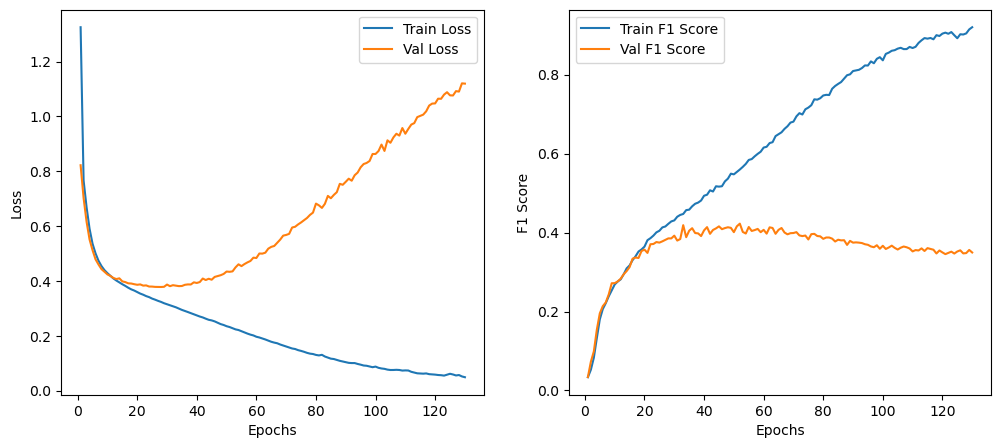

In [21]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()